# **Introducción**

En este cuaderno de Colab, se procesa una imagen para dejar solo el color rojo, el resto pasa a escala de grises.

Para hacer esto, se analiza el valor de color de cada pixel y se determina si dejarlo del mismo color, o pasarlo gris.

# **Armado del ambiente**
Ingresar la imagen a procesar

In [2]:
url_imagen = "https://e00-elmundo.uecdn.es/assets/multimedia/imagenes/2018/11/30/15435965156800.jpg" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg


--2020-11-22 18:51:35--  https://e00-elmundo.uecdn.es/assets/multimedia/imagenes/2018/11/30/15435965156800.jpg
Resolving e00-elmundo.uecdn.es (e00-elmundo.uecdn.es)... 52.85.146.114, 52.85.146.102, 52.85.146.70, ...
Connecting to e00-elmundo.uecdn.es (e00-elmundo.uecdn.es)|52.85.146.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350192 (342K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 341.98K  --.-KB/s    in 0.007s  

2020-11-22 18:51:35 (46.7 MB/s) - ‘imagen.jpg’ saved [350192/350192]



# **Desarrollo CPU**

Tiempo de conversión de imagen: 4557.315 [ms]
Tiempo Total: 4601.868 [ms]


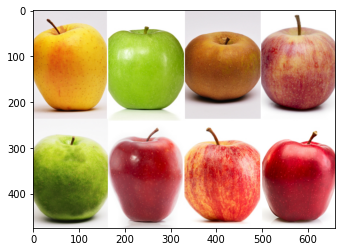

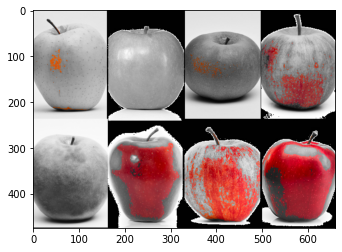

In [7]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

def tiempo_en_ms(dt):
  return (dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = "imagen.jpg"
image = Image.open(img_nombre) 
  
img_alto, img_ancho = image.size 

image_array = np.asarray(image)
image_array_resultado = np.empty_like(image_array)

plt.figure()
imgplot=plt.imshow(image_array)
tiempo_img = datetime.now()

for y  in range(0, img_alto):
  for x in range(0, img_ancho):
    pixel_R, pixel_G, pixel_B = image_array[x][y]
    if pixel_R > 128 and pixel_R > 2.2*pixel_G and pixel_R > 2.2*pixel_B:
      image_array_resultado[x][y] = [pixel_R, pixel_G, pixel_B]
    else:
      gris = (pixel_R*0.299)+(pixel_G*0.599)+(pixel_B*0.11)
      image_array_resultado[x][y] = [gris, gris, gris]

tiempo_img = datetime.now() - tiempo_img

plt.figure()
imgplot = plt.imshow(image_array_resultado)

tiempo_total = datetime.now() - tiempo_total

print("Tiempo de conversión de imagen: {0:.3f} [ms]".format(tiempo_en_ms(tiempo_img)))
print("Tiempo Total: {0:.3f} [ms]".format(tiempo_en_ms(tiempo_total)))

In [2]:
!pip install pycuda

# **Desarrollo GPU**

Imagen original
Tiempo de conversión de imagen: 0.780 [ms]
Tiempo Total: 50.306 [ms]


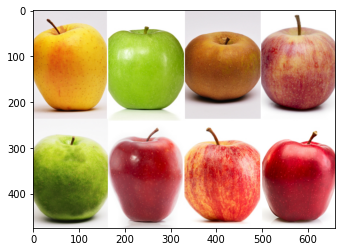

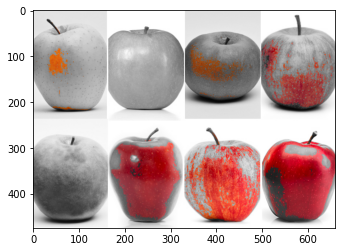

In [6]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

def tiempo_en_ms(dt):
  return (dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = "imagen.jpg"
image = Image.open(img_nombre) 
  
img_alto, img_ancho = image.size 

image_array = np.asarray(image)
# image_array = image_array.astype(np.uint8)
image_array_resultado = np.empty_like(image_array)

image_array_gpu = cuda.mem_alloc(image_array.flatten().nbytes)
image_array_resultado_gpu = cuda.mem_alloc(image_array_resultado.flatten().nbytes)

cuda.memcpy_htod(image_array_gpu, image_array)
cuda.memcpy_htod(image_array_resultado_gpu, image_array_resultado)

module = SourceModule("""
__global__ void kernel_img(int ancho, int alto, unsigned char *img_array, unsigned char *image_array_resultado)
{
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float gris = 0.0;

  if( idx < ancho && idy < alto )
  {
    float pixel_R = (float)img_array[(idx+(idy*ancho))*3];
    float pixel_G = (float)img_array[((idx+(idy*ancho))*3)+1];
    float pixel_B = (float)img_array[((idx+(idy*ancho))*3)+2];

    if(!(pixel_R > 128 && (pixel_R > 2 * pixel_G) && (pixel_R > 2 * pixel_B)))
    {
      //si el pixel actual no es rojo, lo paso a grises
      gris = (pixel_R * 0.299) + (pixel_G * 0.599) + (pixel_B * 0.102);

      pixel_R = gris;
      pixel_G = gris;
      pixel_B = gris;
    }

    image_array_resultado[(idx+(idy*ancho))*3] = (unsigned char) pixel_R;
    image_array_resultado[(idx+(idy*ancho))*3+1] = (unsigned char) pixel_G;
    image_array_resultado[(idx+(idy*ancho))*3+2] = (unsigned char) pixel_B;
  }
}
""") 

print("Imagen original")  
plt.figure()
imgplot=plt.imshow(image_array)
tiempo_img = datetime.now()

kernel = module.get_function("kernel_img")

dim_hilo_x = 16
dim_bloque_x = np.int((img_ancho+dim_hilo_x-1) / dim_hilo_x)

dim_hilo_y = 16
dim_bloque_y = np.int((img_alto+dim_hilo_y-1) / dim_hilo_y)

kernel(np.int32(img_ancho), np.int32(img_alto), image_array_gpu, image_array_resultado_gpu,
       block=(dim_hilo_x, dim_hilo_y, 1), grid=(dim_bloque_x, dim_bloque_y,1))

cuda.memcpy_dtoh(image_array_resultado, image_array_resultado_gpu)

tiempo_img = datetime.now() - tiempo_img

plt.figure()
imgplot = plt.imshow(image_array_resultado)

tiempo_total = datetime.now() - tiempo_total

print("Tiempo de conversión de imagen: {0:.3f} [ms]".format(tiempo_en_ms(tiempo_img)))
print("Tiempo Total: {0:.3f} [ms]".format(tiempo_en_ms(tiempo_total)))
